In [176]:
import numpy as np
import tensorflow as tf

import keras

from tensorflow.keras import layers, Model

from tensorflow.keras.losses import MeanSquaredError, binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

import matplotlib.pyplot as plt

In [177]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [178]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')
x_train = (x_train / 255.0)

In [179]:
label_names = {
    'airplane' : 0 ,
    'automobile' : 1,
    'bird' : 2,
    'cat': 3,
    'deer' : 4,
    'dog' : 5,
    'frog' : 6,
    'horse' : 7,
    'ship' : 8,
    'truck' : 9
}

label_names

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [180]:
# Perform one-hot encoding on the labels
num_classes = 10
y_train_one_hot = np.eye(num_classes)[y_train.flatten()]
y_test_one_hot = np.eye(num_classes)[y_test.flatten()]

# Reshape one-hot encoded labels to match the original shape
y_train_one_hot = y_train_one_hot.reshape(y_train.shape[0], num_classes)
y_test_one_hot = y_test_one_hot.reshape(y_test.shape[0], num_classes)

# Print shapes to verify
print("Shape of original training labels:", y_train.shape)
print("Shape of one-hot encoded training labels:", y_train_one_hot.shape)
print("Shape of original testing labels:", y_test.shape)
print("Shape of one-hot encoded testing labels:", y_test_one_hot.shape)

Shape of original training labels: (50000, 1)
Shape of one-hot encoded training labels: (50000, 10)
Shape of original testing labels: (10000, 1)
Shape of one-hot encoded testing labels: (10000, 10)


In [181]:
latent_dim = 1024
image_shape = x_train[0].shape
print(image_shape)

(32, 32, 3)


In [182]:
mse_loss = MeanSquaredError()

In [183]:
def plot_generated_images(generated_images, num_images_to_generate, label_name):
    plt.figure(figsize=(10, 5))

    for i in range(num_images_to_generate):
        plt.subplot(1, num_images_to_generate, i + 1)
        plt.imshow(generated_images[i])
        plt.title(f'{label_name} Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [184]:
def generate_images_from_latent_vectors(decoder, num_images_to_generate, label):
    # Prepare label vector for the "horse" class
    label_vector = np.zeros((num_images_to_generate, 10))
    label_index = label 
    label_vector[:, label_index] = 1

    # Generate random latent vectors
    random_latent_vectors = np.random.normal(size=(num_images_to_generate, latent_dim))

    # Concatenate latent vectors with the label vector for the "horse" class
    latent_with_label = np.concatenate([random_latent_vectors, label_vector], axis=1)

    # Decode the latent vectors to generate images
    generated_images = decoder.predict(latent_with_label)

    return generated_images

In [185]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim, image_shape, num_classes, beta):
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.image_shape = image_shape
        self.num_classes = num_classes
        self.beta = beta
        
        # Reparameterization/sampling layer 
        self.z_mean = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")
        
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=image_shape, name="Encoder_Input_Layer"),
            layers.Conv2D(64, 5, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_1"),
            layers.Conv2D(128, 5, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_2"),
            layers.Conv2D(256, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_3"),
            layers.Conv2D(512, 3, strides=1, activation='relu', padding='same', name="Encoder_Conv2D_4"),
            layers.Flatten(name="Encoder_Flatten"),
            layers.Dense(latent_dim + latent_dim, name="Encoder_Dense_3"),
        ])

        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim + num_classes,), name="Decoder_Input_Layer"),
            layers.Dense(8*8*256, activation='relu'),  
            layers.Reshape((8, 8, 256)),
            layers.Conv2DTranspose(256, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'),  
            layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
        ])

        
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
     
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var
    
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z
    
    def call(self, inputs):
        x, labels = inputs
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)

        z_with_labels = tf.concat([z, labels], axis=-1)
        x_recon = self.decoder(z_with_labels)

        x_recon_sharp = self.sharpen(x_recon)
        return x_recon_sharp, mean, logvar
    
    def decode(self, data):
        return self.decoder(data)
    
    def sharpen(self, image):
        # Define an edge-enhancing filter
        kernel = tf.constant([[[[0, -1, 0],
                                [-1, 5, -1],
                                [0, -1, 0]]]], dtype=tf.float32)
        # Apply convolution separately to each channel
        sharpened_image = tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding='SAME')
        # Clip values to ensure they are in the valid range [0, 1]
        sharpened_image = tf.clip_by_value(sharpened_image, 0.0, 1.0)
        return sharpened_image



        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def recon_loss(self, data, reconstruction):
        return tf.reduce_mean(binary_crossentropy(data, reconstruction))

    def kl_divergence(self, z_log_var, z_mean):
        kl = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        return self.beta * kl

    def train_step(self, data):
        x = data[0][0]
        labels  = data[0][1]
#         x, labels = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(x)
            z = self.reparameterization(z_mean, z_log_var)      
            # Concatenate labels with z
            z_with_labels = tf.concat([z, labels], axis=-1)
            reconstruction = self.decoder(z_with_labels)
            # Apply sharpening filter
#             reconstruction_sharp = self.sharpen(reconstruction)

            reconstruction_loss = self.recon_loss(x, reconstruction)
            kl_loss = self.kl_divergence(z_log_var, z_mean)
            
            total_loss = reconstruction_loss + kl_loss 
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [186]:
cvae = CVAE(latent_dim, image_shape, 10, 0.2)
cvae.decoder.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 16384)          │    16,957,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_52             │ (None, 8, 8, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_53             │ (None, 16, 16, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_54             │ (None, 32, 32, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_55             │ (None, 32, 32, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,573,443 (70.85 MB)

 Trainable params: 18,573,443 (70.85 MB)

 Non-trainable params: 0 (0.00 B)

In [187]:
cvae.encoder.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder_Conv2D_1 (Conv2D)       │ (None, 16, 16, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv2D_2 (Conv2D)       │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv2D_3 (Conv2D)       │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv2D_4 (Conv2D)       │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Flatten (Flatten)       │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Dense_3 (Dense)         │ (None, 2048)           │    16,779,264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,464,384 (70.44 MB)

 Trainable params: 18,464,384 (70.44 MB)

 Non-trainable params: 0 (0.00 B)

In [188]:
early_stopping = EarlyStopping(monitor='loss', patience=4, verbose=1)
cvae.compile(optimizer=keras.optimizers.Adam())
history = cvae.fit([x_train, y_train_one_hot], epochs=50, batch_size=256, callbacks=[early_stopping])

Epoch 1/50
  3/196 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - kl_loss: 3.3528e-06 - loss: 0.6929 - reconstruction_loss: 0.6929  

W0000 00:00:1712658113.065097      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712658113.069247      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


196/196 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - kl_loss: 8.4745e-04 - loss: 0.6690 - reconstruction_loss: 0.6680 - total_loss: 0.6443
Epoch 2/50
  2/196 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - kl_loss: 0.0023 - loss: 0.6127 - reconstruction_loss: 0.6105

W0000 00:00:1712658127.179916      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - kl_loss: 0.0023 - loss: 0.6119 - reconstruction_loss: 0.6096 - total_loss: 0.6081
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - kl_loss: 0.0032 - loss: 0.5987 - reconstruction_loss: 0.5956 - total_loss: 0.5975
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - kl_loss: 0.0036 - loss: 0.5926 - reconstruction_loss: 0.5891 - total_loss: 0.5918
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - kl_loss: 0.0035 - loss: 0.5883 - reconstruction_loss: 0.5848 - total_loss: 0.5874
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - kl_loss: 0.0033 - loss: 0.5850 - reconstruction_loss: 0.5817 - total_loss: 0.5841
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - kl_loss: 0.0031 - loss: 0.5827 - reconstruction_loss: 0.5795 - total_loss: 0.5815
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - kl_loss: 0.0030 - loss: 0.5807 - reconstruction_loss: 0.5776 - total_loss: 0.5796
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 5

In [189]:
# from datetime import datetime
# timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
# vae.save("vae_" + timestamp + ".h5")

In [190]:
history.history.keys()

dict_keys(['kl_loss', 'reconstruction_loss', 'total_loss'])

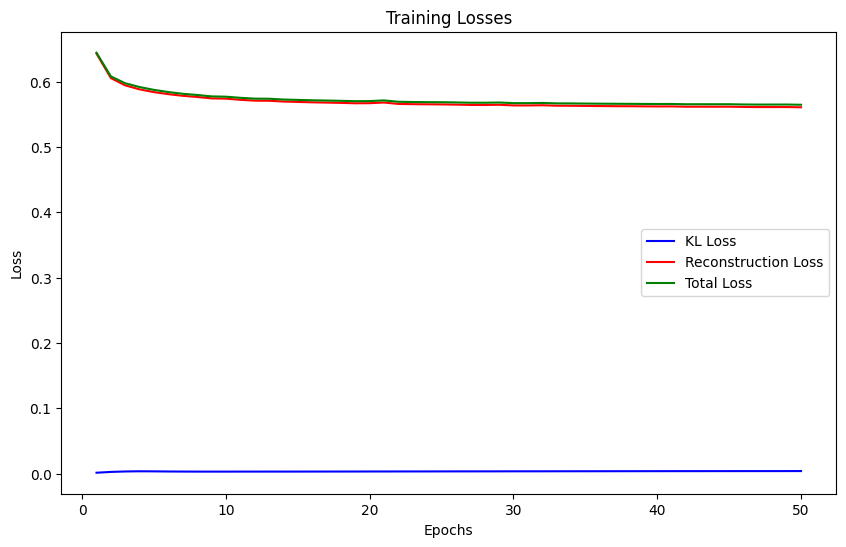

In [191]:
kl_loss = history.history['kl_loss']
reconstruction_loss = history.history['reconstruction_loss']
total_loss = history.history['total_loss']

# Plot the losses
epochs = range(1, len(kl_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, kl_loss, 'b', label='KL Loss')
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction Loss')
plt.plot(epochs, total_loss, 'g', label='Total Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


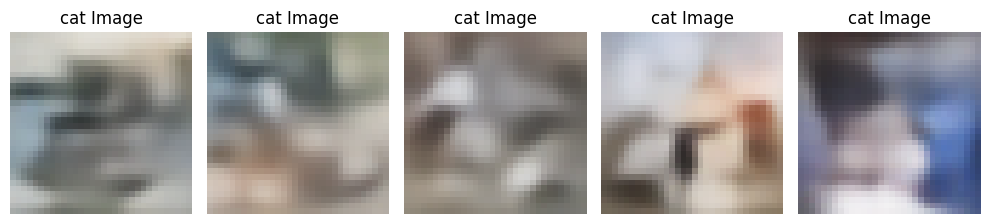

In [196]:
num_images = 5  
label_name = "cat"
label_index = label_names[label_name]
generated_images = generate_images_from_latent_vectors(cvae.decoder, num_images, label_index)

plot_generated_images(generated_images, num_images, label_name)